In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=5000)
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib widget

import pycolmap

from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch

from plyfile import PlyData

def pprint(array, precision=4):
    with np.printoptions(
        precision=precision,
        suppress=True,
    ):
        print(array)


## Load camera parameters

load image and camera parameter from colmap output folder using pycolmap

In [2]:
colmap_dir = Path('/home/linus/workspace/data/mipnerf/bicycle/sparse/0/')
images_dir = Path('/home/linus/workspace/data/mipnerf/bicycle/images')
colmap_output = pycolmap.Reconstruction(colmap_dir)

colmap_image = colmap_output.images[1]
colmap_camera = colmap_output.cameras[colmap_image.camera_id]

width, height = colmap_camera.width, colmap_camera.height
fx, fy = colmap_camera.focal_length_x, colmap_camera.focal_length_y

view_matrix = np.vstack([colmap_image.cam_from_world.matrix(), [0, 0, 0, 1]])

### NDC matrix

The next cell creates the NDC matrix, which transforms camera-centered coordinates to (right handed) Normalized Device Coordinates (NDC)

This matrix maps the camera frustum between `z=near` and `z=far` to a [-1,1]x[-1,1]x[0,1] cube

See [here](http://www.songho.ca/opengl/gl_projectionmatrix.html) or [here](https://www.scratchapixel.com/lessons/3d-basic-rendering/perspective-and-orthographic-projection-matrix/building-basic-perspective-projection-matrix.html) for more info and some visualizations

NOTE: As in the original implementation, this transformation assumes the camera center is in the middle of the image. There is a possible fix here: https://github.com/graphdeco-inria/gaussian-splatting/issues/144 though I haven't tried it

In [3]:
near, far = 0.01, 100 # hard-coded here https://github.com/graphdeco-inria/gaussian-splatting/blob/0b3519bca56e0ab38f85d5aa15d8aae7f526a4fe/scene/cameras.py#L48
tan_half_fov_x = width / 2 / fx
tan_half_fov_y = height / 2 / fy
ndc_matrix = np.array([
    [1/tan_half_fov_x, 0, 0, 0],
    [0, 1/tan_half_fov_y, 0, 0],
    [0, 0, far/(far-near), -near*far/(far-near)],
    [0, 0, 1, 0],
])

image = np.array(Image.open(images_dir / f'{colmap_image.name}'))
proj_matrix = ndc_matrix @ view_matrix

In [11]:
def dehomogenize(a):
    return a[:-1] / a[-1]

x_near, x_far = near * tan_half_fov_x, far * tan_half_fov_x
y_near, y_far = near * tan_half_fov_y, far * tan_half_fov_y
pprint(dehomogenize(ndc_matrix @ np.array([x_near, y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_near, -y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_near, y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_near, -y_near, near, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_far, y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([x_far, -y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_far, y_far, far, 1])))
pprint(dehomogenize(ndc_matrix @ np.array([-x_far, -y_far, far, 1])))

[1. 1. 0.]
[ 1. -1.  0.]
[-1.  1.  0.]
[-1. -1.  0.]
[1. 1. 1.]
[ 1. -1.  1.]
[-1.  1.  1.]
[-1. -1.  1.]


# Load gaussian splatting output

In [5]:
plydata = PlyData.read('/home/linus/workspace/gaussian-splatting/output/ab091260-1/point_cloud/iteration_1000/point_cloud.ply').elements[0]
means = np.array([
    plydata['x'],
    plydata['y'],
    plydata['z'],
]).T
n_gaussians = len(means)
opacities = plydata['opacity']
features_dc = np.array([
    plydata['f_dc_0'],
    plydata['f_dc_1'],
    plydata['f_dc_2'],
]).T

extra_f_names = [p.name for p in plydata.properties if p.name.startswith("f_rest_")]
extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
max_sh_degree = int(np.sqrt(len(extra_f_names) / 3 + 1) - 1)

features_extra = np.array([
    plydata[extra_f_name]
    for extra_f_name in extra_f_names
]).T.reshape((n_gaussians, -1, 3))

features = np.concatenate([features_dc[:, None], features_extra], axis=1)

scales = np.array([
    plydata['scale_0'],
    plydata['scale_1'],
    plydata['scale_2'],
]).T

quaternions = np.array([
    plydata['rot_0'],
    plydata['rot_1'],
    plydata['rot_2'],
    plydata['rot_3'],
]).T

# Render splats

In [6]:
resolution_factor = 8
settings = GaussianRasterizationSettings(
    image_height=round(height / resolution_factor),
    image_width=round(width / resolution_factor),
    tanfovx=tan_half_fov_x,
    tanfovy=tan_half_fov_y,
    bg=torch.zeros(3, device="cuda"),
    scale_modifier=1.,
    viewmatrix=torch.tensor(view_matrix, device="cuda", dtype=torch.float32).T,
    projmatrix=torch.tensor(proj_matrix, device="cuda", dtype=torch.float32).T,
    sh_degree=max_sh_degree,
    campos=torch.tensor(np.linalg.inv(view_matrix)[:3, -1], device="cuda", dtype=torch.float32),
    prefiltered=False,
    debug=True,
)
rasterizer = GaussianRasterizer(settings)

In [7]:
skip = 1
rendered_image, radii = rasterizer(
    means3D=torch.tensor(means[::skip].copy(), device="cuda"),
    means2D=torch.zeros(means[::skip].copy().shape, device="cuda"),
    opacities=torch.sigmoid(torch.tensor(opacities[::skip, None].copy(), device="cuda")),
    shs=torch.tensor(features[::skip].copy(), device="cuda"),
    scales=torch.exp(torch.tensor(scales[::skip].copy(), device="cuda")),
    rotations=torch.nn.functional.normalize(torch.tensor(quaternions[::skip].copy(), device="cuda")),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


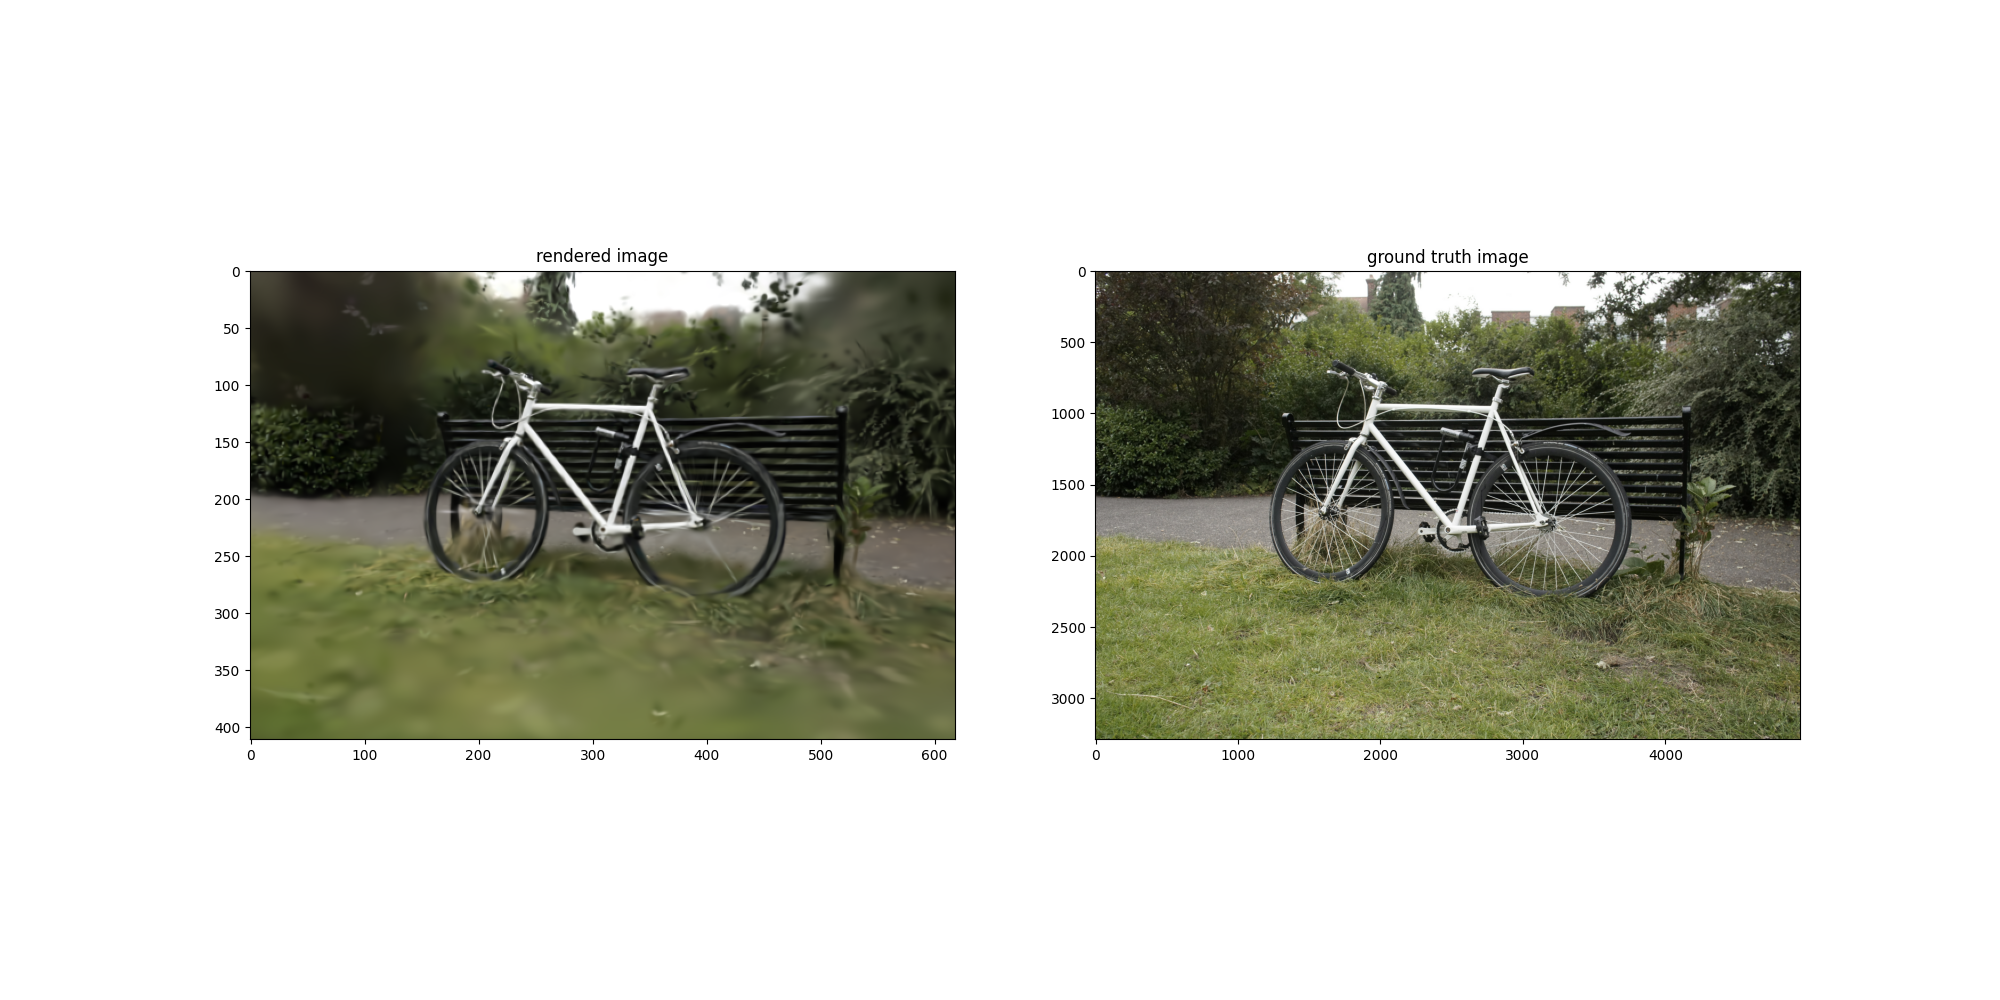

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title('rendered image')
ax[0].imshow(rendered_image.detach().cpu().numpy().transpose(1, 2, 0))

ax[1].set_title('ground truth image')
ax[1].imshow(image)